# Deep Kernel Learning with KAN

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import os
from kan import KANLayer, KAN, LBFGS
import gpytorch
import math
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

try:
    chdir_bool
except NameError:
    os.chdir(os.getcwd() + "/..")
    chdir_bool = True

import warnings
warnings.filterwarnings("ignore")

In [14]:
# Hyperparameters
seed = 111
np.random.seed(seed)
torch.manual_seed(seed)
epochs = 50

In [15]:
# data
data = torch.Tensor(loadmat("data/elevators.mat")["data"])

X = data[:, :-1]
X -= X.mean(dim=0)
X = 2 * (X / X.max(dim=0, keepdim=True).values) - 1
y = data[:, -1]

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([13279, 18]) torch.Size([3320, 18]) torch.Size([13279]) torch.Size([3320])


In [16]:
# DKL
data_dim = X_train.shape[1]

class FeatureExtractor(nn.Sequential):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.add_module('linear1', nn.Linear(data_dim, 64))
        self.add_module('relu1', nn.ReLU())
        self.add_module('linear2', nn.Linear(64, 16))
        self.add_module('relu2', nn.ReLU())
        self.add_module('linear3', nn.Linear(16, 2))

feature_extractor = FeatureExtractor()

In [17]:
class GPR(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPR, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
            num_dims=2, grid_size=100
        )
        self.feature_extractor = feature_extractor
        self.scaler = gpytorch.utils.grid.ScaleToBounds(-1, 1)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.scaler(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [18]:
torch.manual_seed(seed)

# Training
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPR(X_train, y_train, likelihood)

# number of parameters
n_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {n_params}")

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Loss
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

train_losses = []
val_mses = []
val_mlls = []

iterator = tqdm(range(epochs), desc='Epochs', leave=True)

for epoch in iterator:
    model.train()
    likelihood.train()

    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    # Validation loss
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        output = model(X_test)
        val_mll = -mll(output, y_test)
        val_loss = torch.nn.MSELoss()(output.mean, y_test)
        val_mses.append(val_loss.item())
        val_mlls.append(val_mll.item())

    iterator.set_postfix({'loss': loss.item(), 'val_loss': val_loss.item()})

mlp_losses = dict(train_losses=train_losses, val_mses=val_mses, val_mlls=val_mlls)

Number of parameters: 2295


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

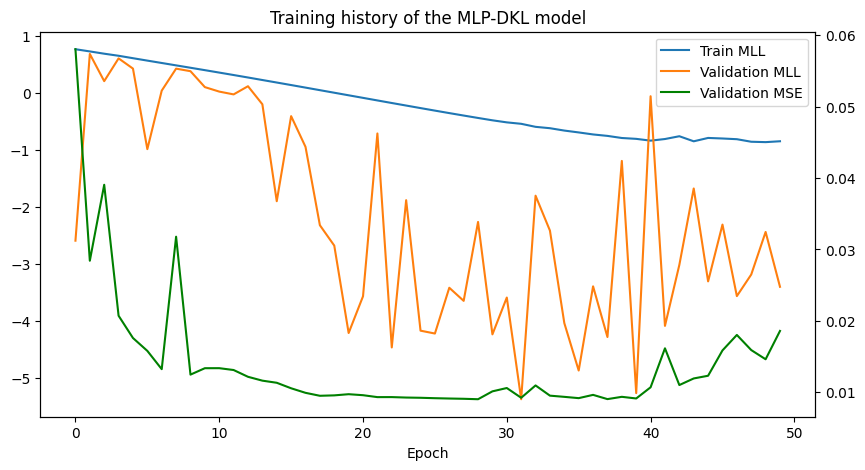

In [19]:
# History plot


fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.twinx()
ax.plot(mlp_losses["train_losses"], label="Train MLL")
ax.plot(mlp_losses["val_mlls"], label="Validation MLL")
ax2.plot(mlp_losses["val_mses"], label="Validation MSE", color='green')
ax.set_xlabel("Epoch")
plt.legend([ax.get_lines()[0], ax.get_lines()[1], ax2.get_lines()[0]], ["Train MLL", "Validation MLL", "Validation MSE"])
plt.title("Training history of the MLP-DKL model")
plt.show()

## KAN

In [20]:
# hyperparameters
hidden_dim = 5

In [21]:
# KAN based model

class KAN_extractor(nn.Module):
    def __init__(self):
        super(KAN_extractor, self).__init__()
        self.kan1 = KANLayer(
            data_dim, hidden_dim,
            num=5, k=3, base_fun=torch.nn.SiLU())
        self.kan2 = KANLayer(hidden_dim, 2,
            num=5, k=3, base_fun=torch.nn.SiLU())

    def forward(self, x):
        x1, *_ = self.kan1(x)
        x2, *_ = self.kan2(x1)
        return x2
        
kan_extractor = KAN_extractor()

class KAN_GPR(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(KAN_GPR, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
            num_dims=2, grid_size=50
        )
        self.feature_extractor = kan_extractor
        self.scaler = gpytorch.utils.grid.ScaleToBounds(-1, 1)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.scaler(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [22]:
torch.manual_seed(seed)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
kan_model = KAN_GPR(X_train, y_train, likelihood)

# number of parameters
print(f"Number of parameters: {sum(p.numel() for p in kan_model.parameters())}")

# Use the adam optimizer
optimizer = torch.optim.Adam(kan_model.parameters(), lr=0.1)

# Loss
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, kan_model)

train_losses = []
val_mses = []
val_mlls = []

iterator = tqdm(range(epochs), desc='Epochs', leave=True)

for epoch in iterator:
    kan_model.train()
    likelihood.train()

    # Output from model
    output = kan_model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation loss
    kan_model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        output = kan_model(X_test)
        val_mll = -mll(output, y_test)
        val_loss = torch.nn.MSELoss()(output.mean, y_test)
        val_mses.append(val_loss.item())
        val_mlls.append(val_mll.item())

    iterator.set_postfix({'loss': train_losses[-1], 'val_loss': val_loss.item()})

kan_losses = dict(train_losses=train_losses, val_mses=val_mses, val_mlls=val_mlls)

Number of parameters: 1705


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

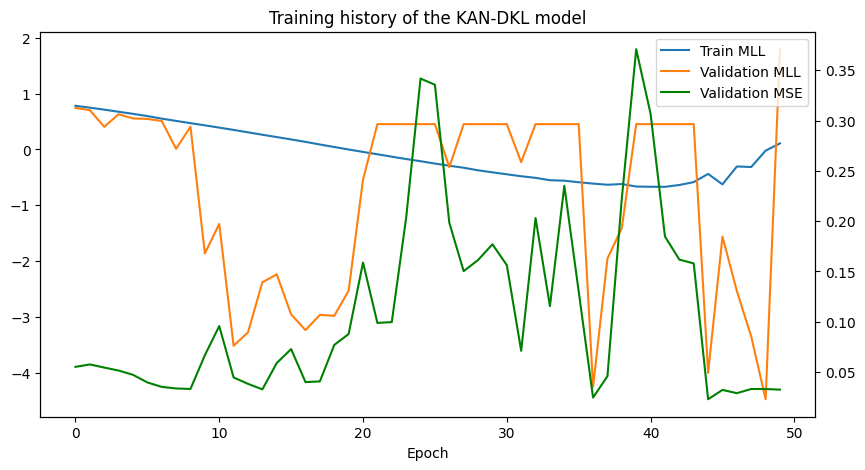

In [23]:
# History plot
fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.twinx()
ax.plot(kan_losses["train_losses"], label="Train MLL")
ax.plot(kan_losses["val_mlls"], label="Validation MLL")
ax2.plot(kan_losses["val_mses"], label="Validation MSE", color='green')
ax.set_xlabel("Epoch")
plt.legend([ax.get_lines()[0], ax.get_lines()[1], ax2.get_lines()[0]], ["Train MLL", "Validation MLL", "Validation MSE"])
plt.title("Training history of the KAN-DKL model")
plt.show()

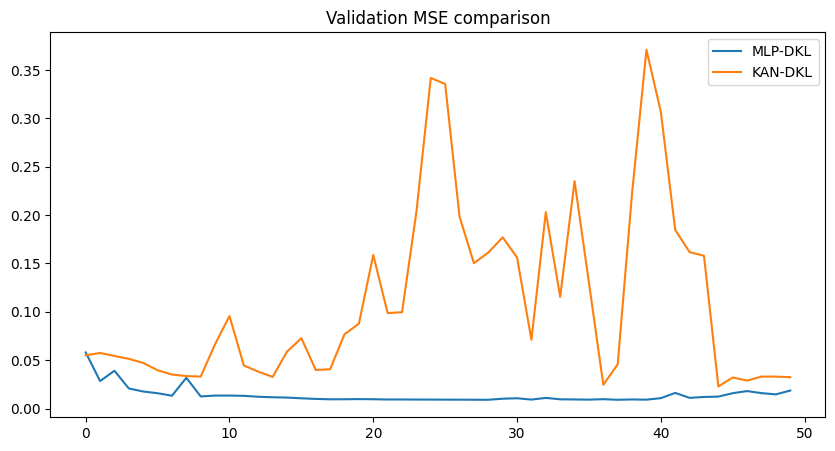

In [24]:
# Compare two MSEs
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mlp_losses["val_mses"], label="MLP-DKL")
ax.plot(kan_losses["val_mses"], label="KAN-DKL")
plt.legend()
plt.title("Validation MSE comparison")
plt.show()